> In total there are two notebooks for this project. This notebook is the first one with the purpose of examining the distributions of the features and the correlations among the variables, followed by cleaning (imputing missing values, outlier selection, feature selection, feature engineering) of the datasets to get them ready for modeling.

## Problem Statement

Construct a model that can be used to predict the final price of each home using the explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa.

# 1. Exploratory Data Analysis (EDA)

In [1]:
# Import the libraries

import numpy as np 
import pandas as pd 
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt  
import seaborn as sns

from scipy import stats
from scipy.stats import norm, skew 

sns.set_style('whitegrid')

In [2]:
# Load the dataset

train_df = pd.read_csv('../datasets/train.csv')
test_df = pd.read_csv('../datasets/test.csv')

## Examine the datasets

In [3]:
# Have a feel how the data looks like
train_df.head()

Id        PID  MS SubClass MS Zoning  Lot Frontage  Lot Area Street Alley  \
0  109  533352170           60        RL           NaN     13517   Pave   NaN   
1  544  531379050           60        RL          43.0     11492   Pave   NaN   
2  153  535304180           20        RL          68.0      7922   Pave   NaN   
3  318  916386060           60        RL          73.0      9802   Pave   NaN   
4  255  906425045           50        RL          82.0     14235   Pave   NaN   

  Lot Shape Land Contour  ... Screen Porch Pool Area Pool QC Fence  \
0       IR1          Lvl  ...            0         0     NaN   NaN   
1       IR1          Lvl  ...            0         0     NaN   NaN   
2       Reg          Lvl  ...            0         0     NaN   NaN   
3       Reg          Lvl  ...            0         0     NaN   NaN   
4       IR1          Lvl  ...            0         0     NaN   NaN   

  Misc Feature Misc Val Mo Sold Yr Sold  Sale Type  SalePrice  
0          NaN        0       3    2010        WD      130500  
1          NaN        0       4    2009        WD      220000  
2          NaN        0       1    2010        WD      109000  
3          NaN        0       4    2010        WD      174000  
4          NaN        0       3    2010        WD      138500  

[5 rows x 81 columns]

In [4]:
# Check the number of rows/cols
train_df.shape

(2051, 81)

In [5]:
test_df.shape

(879, 80)

In [6]:
# Check the data types & possible null values
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 81 columns):
Id                 2051 non-null int64
PID                2051 non-null int64
MS SubClass        2051 non-null int64
MS Zoning          2051 non-null object
Lot Frontage       1721 non-null float64
Lot Area           2051 non-null int64
Street             2051 non-null object
Alley              140 non-null object
Lot Shape          2051 non-null object
Land Contour       2051 non-null object
Utilities          2051 non-null object
Lot Config         2051 non-null object
Land Slope         2051 non-null object
Neighborhood       2051 non-null object
Condition 1        2051 non-null object
Condition 2        2051 non-null object
Bldg Type          2051 non-null object
House Style        2051 non-null object
Overall Qual       2051 non-null int64
Overall Cond       2051 non-null int64
Year Built         2051 non-null int64
Year Remod/Add     2051 non-null int64
Roof Style         20

2 redundant columns, 78 features, and the last column 'saleprice' being the target variable. 

### **Drop the 'PID' column. I will keep 'Id' column as this is the identifier required for kaggle score calculation**

In [7]:
train_df.drop(['PID'],axis=1,inplace=True)
test_df.drop(['PID'],axis=1,inplace=True)

### **Rename column names to lowercase without spaces**

In [8]:
train_df.rename(columns=lambda x:x.strip().lower().replace(" ","_"),inplace=True)
test_df.rename(columns=lambda x:x.strip().lower().replace(" ","_"),inplace=True)

### **Check target variable distribution - we can see that saleprice has a noticeable positive skew:**

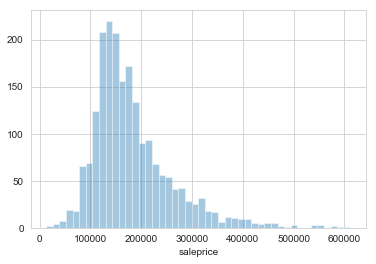

In [9]:
sns.distplot(train_df['saleprice'], kde=False);

Try (log+1) transform and examine the distribution of saleprice

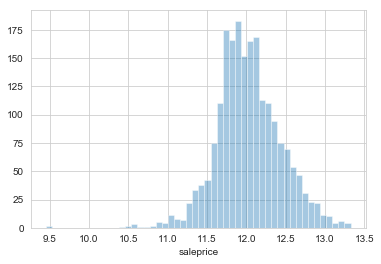

In [10]:
sns.distplot(np.log1p(train_df['saleprice']), kde=False);

Since this looks closer to a normal distribution and linear regression works better for approximately normal target variables, let's log transform our sale price:

In [11]:
train_df['saleprice'] = np.log1p(train_df['saleprice'])

### **Check the correlation between the features and the target variable**

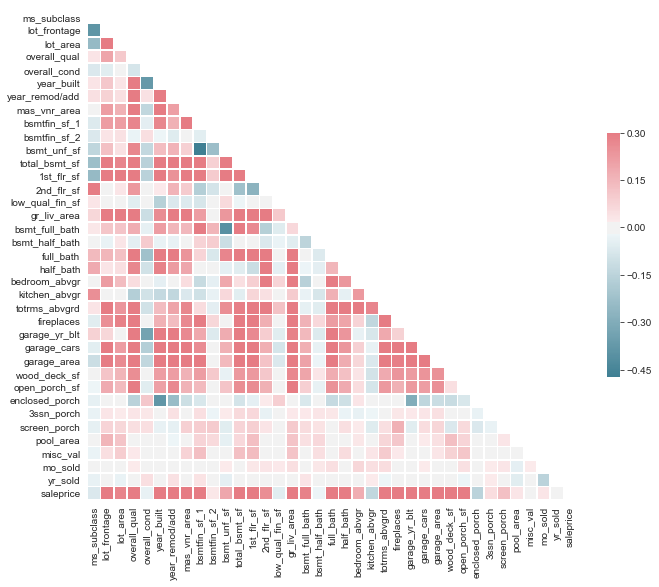

In [12]:
variables = [x for x in train_df.columns if x not in ['id']]

# Compute the correlation matrix
corr = train_df[variables].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});

In [13]:
corr = corr.sort_values(['saleprice'], ascending=False)
print(corr.saleprice.head(10))

saleprice         1.000000
overall_qual      0.822775
gr_liv_area       0.687775
garage_cars       0.667781
garage_area       0.650756
year_built        0.624449
total_bsmt_sf     0.621417
year_remod/add    0.599459
1st_flr_sf        0.599087
garage_yr_blt     0.581093
Name: saleprice, dtype: float64


We see that overall quality, above ground living area, size and capacity of the garage, the basement/1st floor area, the year when the house was built, and the number of bathrooms are among the mostly correlated variables with saleprice.

# 2. Imputing Missing Values

## Dataset Preparation

### Merge the train and test datasets to apply the same preprocessing methods as a whole.

In [14]:
train_df['dataset'] = 'train'
test_df['dataset'] = 'test'

all_df = pd.concat((train_df, test_df), sort=False).reset_index(drop=True)
all_df.drop(['saleprice'], axis=1, inplace=True)
print("all_df size is : {}".format(all_df.shape))

all_df size is : (2930, 80)


In [15]:
all_df.head()

id  ms_subclass ms_zoning  lot_frontage  lot_area street alley lot_shape  \
0  109           60        RL           NaN     13517   Pave   NaN       IR1   
1  544           60        RL          43.0     11492   Pave   NaN       IR1   
2  153           20        RL          68.0      7922   Pave   NaN       Reg   
3  318           60        RL          73.0      9802   Pave   NaN       Reg   
4  255           50        RL          82.0     14235   Pave   NaN       IR1   

  land_contour utilities  ... screen_porch pool_area pool_qc fence  \
0          Lvl    AllPub  ...            0         0     NaN   NaN   
1          Lvl    AllPub  ...            0         0     NaN   NaN   
2          Lvl    AllPub  ...            0         0     NaN   NaN   
3          Lvl    AllPub  ...            0         0     NaN   NaN   
4          Lvl    AllPub  ...            0         0     NaN   NaN   

  misc_feature misc_val mo_sold  yr_sold  sale_type  dataset  
0          NaN        0       3     2010        WD     train  
1          NaN        0       4     2009        WD     train  
2          NaN        0       1     2010        WD     train  
3          NaN        0       4     2010        WD     train  
4          NaN        0       3     2010        WD     train  

[5 rows x 80 columns]

### Impute missing values - check the columns that have NaN values and decide the next step: how to impute the NaN values? Are they missing values or do they actually have a meaning?**

In [16]:
nan_colnames = pd.DataFrame(all_df.isnull().sum(),columns = ['count'])

In [17]:
nan_colnames = nan_colnames[nan_colnames['count'] > 0]
nan_colnames.sort_values(['count'],ascending = False)

count
pool_qc          2917
misc_feature     2824
alley            2732
fence            2358
fireplace_qu     1422
lot_frontage      490
garage_cond       159
garage_qual       159
garage_finish     159
garage_yr_blt     159
garage_type       157
bsmt_exposure      83
bsmtfin_type_2     81
bsmtfin_type_1     80
bsmt_qual          80
bsmt_cond          80
mas_vnr_area       23
mas_vnr_type       23
bsmt_half_bath      2
bsmt_full_bath      2
total_bsmt_sf       1
bsmt_unf_sf         1
garage_cars         1
garage_area         1
bsmtfin_sf_2        1
bsmtfin_sf_1        1
electrical          1

Referencing the data dictionary, most of the NaN values seem to actually have a meaning, i.e. that the property does not have the feature. Therefore it makes more sense to treat NaN as valid observations and keep them. The NaN cells should be imputed case by case, based on the context of that feature.

* Also keep in mind that we may want to remove the top 4 features that have >95% of values as NaN: **pool_qc, misc_feature, alley, fence**

### Details of Imputing Missing Values

In [18]:
# LotFrontage : group by neighborhood and fill in missing value by the median LotFrontage of all the neighborhood
all_df["lot_frontage"] = all_df.groupby("neighborhood")["lot_frontage"].transform(
    lambda x: x.fillna(x.median()))
# Alley : data description says NA means "no alley access"
all_df["alley"] = all_df["alley"].fillna("None")
# MasVnrType : NA most likely means no veneer
all_df["mas_vnr_type"] = all_df["mas_vnr_type"].fillna("None")
all_df["mas_vnr_area"] = all_df["mas_vnr_area"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
all_df["bsmt_qual"] = all_df["bsmt_qual"].fillna("None")
all_df["bsmt_cond"] = all_df["bsmt_cond"].fillna("None")
all_df["bsmt_exposure"] = all_df["bsmt_exposure"].fillna("None")
all_df["bsmtfin_type_1"] = all_df["bsmtfin_type_1"].fillna("None")
all_df["bsmtfin_type_2"] = all_df["bsmtfin_type_2"].fillna("None")
all_df["bsmtfin_sf_1"] = all_df["bsmtfin_sf_1"].fillna(0)
all_df["bsmtfin_sf_2"] = all_df["bsmtfin_sf_2"].fillna(0)
all_df["bsmt_unf_sf"] = all_df["bsmt_unf_sf"].fillna(0)
all_df["total_bsmt_sf"] = all_df["total_bsmt_sf"].fillna(0)
all_df["bsmt_full_bath"] = all_df["bsmt_full_bath"].fillna(0)
all_df["bsmt_half_bath"] = all_df["bsmt_half_bath"].fillna(0)
# Electrical : It has one NA value. Since this feature has mostly 'SBrkr', we can set that for the missing value.
all_df['electrical'] = all_df['electrical'].fillna(all_df['electrical'].mode()[0])
# FireplaceQu : data description says NA means "no fireplace"
all_df["fireplace_qu"] = all_df["fireplace_qu"].fillna("None")
# GarageType etc : data description says NA for garage features is "no garage"
all_df["garage_type"] = all_df["garage_type"].fillna("None")
all_df["garage_yr_blt"] = all_df["garage_yr_blt"].fillna(0)
all_df["garage_finish"] = all_df["garage_finish"].fillna("None")
all_df["garage_cars"] = all_df["garage_cars"].fillna(0)
all_df["garage_area"] = all_df["garage_area"].fillna(0)
all_df["garage_qual"] = all_df["garage_qual"].fillna("None")
all_df["garage_cond"] = all_df["garage_cond"].fillna("None")
# PoolQC : data description says NA means "no pool"
all_df["pool_qc"] = all_df["pool_qc"].fillna("None")
# Fence : data description says NA means "no fence"
all_df["fence"] = all_df["fence"].fillna("None")
# MiscFeature : data description says NA means "no misc feature"
all_df["misc_feature"] = all_df["misc_feature"].fillna("None")

In [19]:
# Confirming there are no nan values in the dataframe anymore
nan_colnames_new = pd.DataFrame(all_df.isnull().sum(),columns = ['count'])
nan_colnames_new = nan_colnames_new[nan_colnames_new['count'] > 0]
nan_colnames_new

count
lot_frontage      3

In [20]:
# Replace the Lot Frontage of remaining 3 observations with zero. As there is no neighbourhood data available for reference.
all_df["lot_frontage"] = all_df["lot_frontage"].fillna(0)

# 3. Outlier selection

In [21]:
#define a function that outputs the column list with outliers
def outliers(df):
    outlier_cols = []
    for column in df.columns.to_list():
        if df[column].dtype in ('int64', 'float64'):
            if df[column].max() > df[column].mean() + 3*df[column].std(ddof=0) or \
                df[column].min() < df[column].mean() - 3*df[column].std(ddof=0):
                outlier_cols.append(column)
    return outlier_cols

In [22]:
#define a plot fucntion to get a feel of the outliers correlation to target variable
def subplot_scatterplots(dataframe, list_of_columns, target_var):
    nrows = int(np.ceil(len(list_of_columns)/3)) # Plot in 3 columns
    fig, ax = plt.subplots(nrows=nrows, ncols=3,figsize=(15,50)) 
    plt.subplots_adjust(bottom=0.1, top=0.9)
    ax = ax.ravel() 
    for i, column in enumerate(list_of_columns): 
        sns.scatterplot(x=dataframe[column], y=target_var, data=dataframe, ax=ax[i])

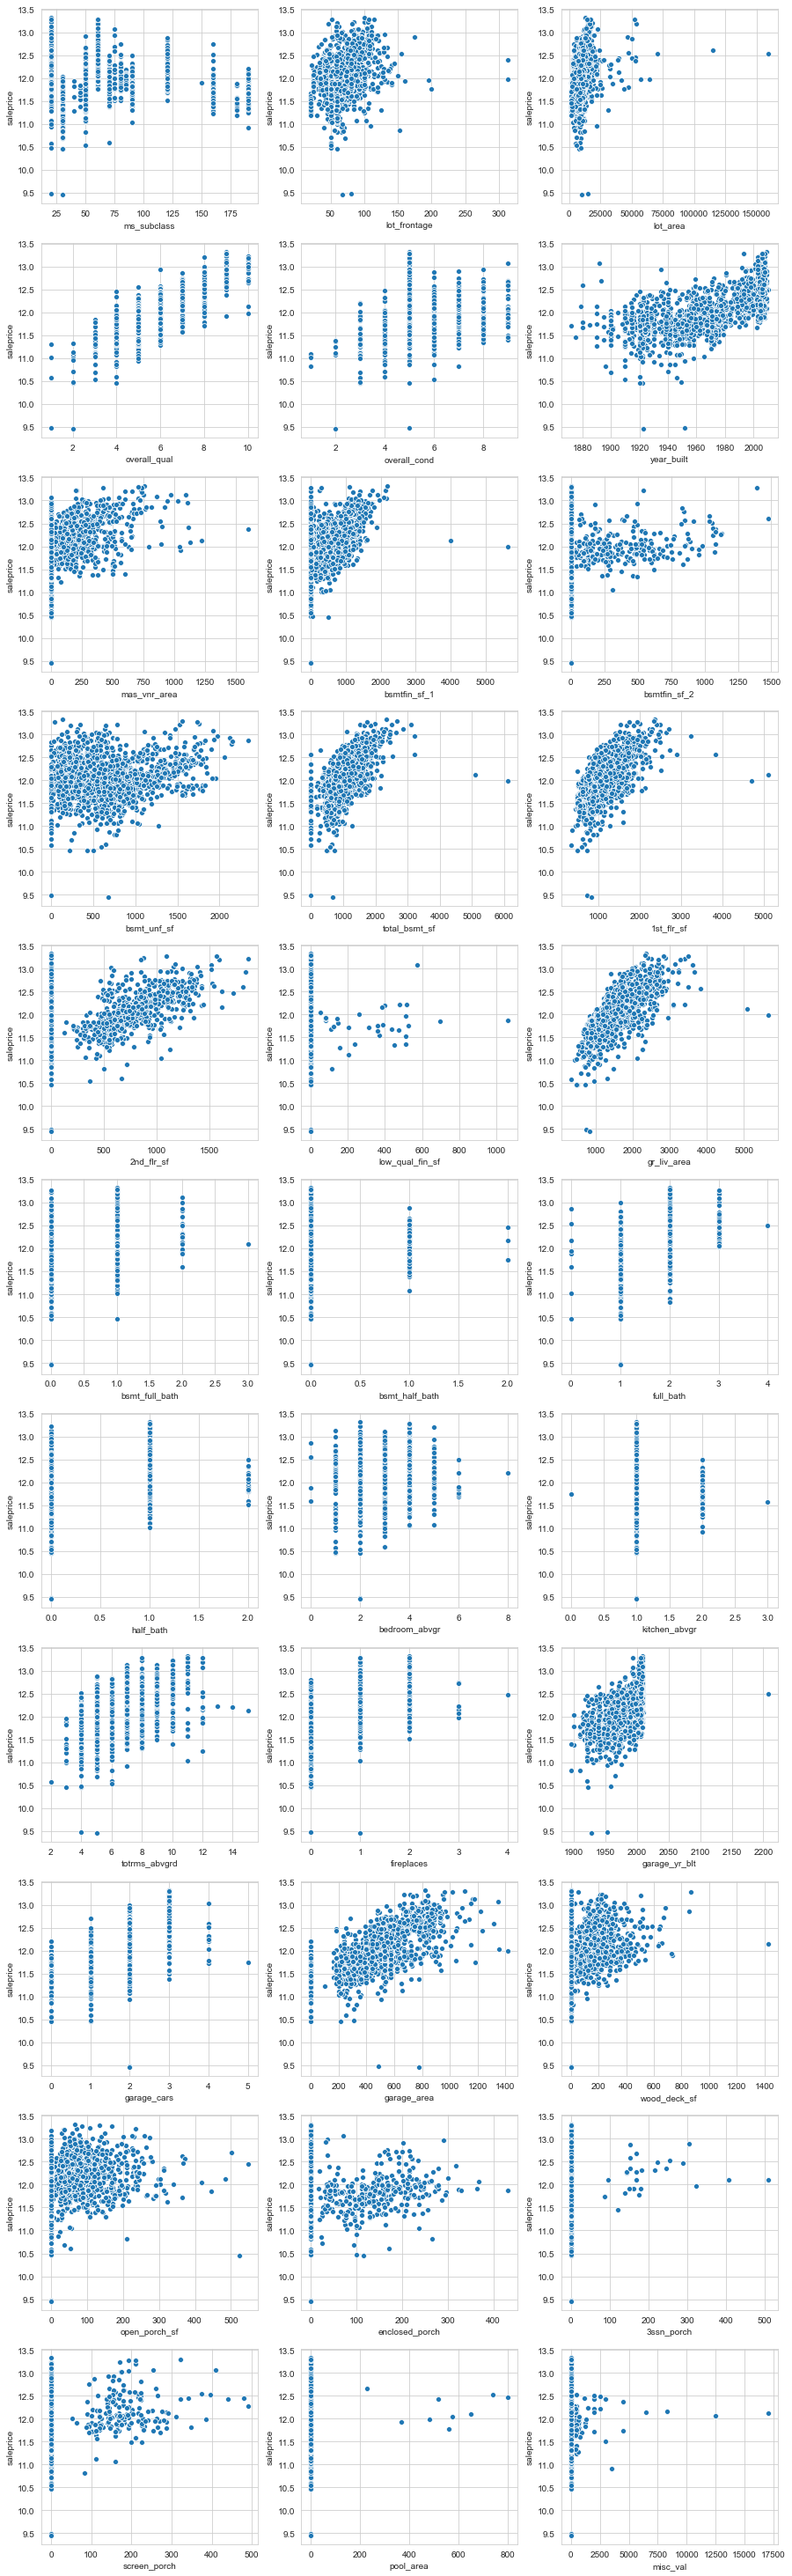

In [23]:
columns_list = outliers(all_df)

subplot_scatterplots(train_df,columns_list,'saleprice')

The observation of the scatter plots above on outlier columns show us 4 types of problems that need to be addressed:
    
`1.` Not all the numeric features make sense to be represented in numeric form here, e.g. **ms_subclass** is actually a categorical variable => similarly, could there be categorical features that don't make sense to be represented in string format? (`Next step of data cleaning`: correct the datatype of features)
    
`2.` Along y-axis, here are notably 2 outliers that have **very low saleprice** (`Next step of data cleaning`: as our dataset is of decent size ~2051 rows in the training dataset, we can take the penalty of removing the outliers) 

`3.` Along x-axis, **bsmtfin_sf_1, total_bsmt_sf, 1st_flr_sf, gr_liv_area, wood_deck_sf** had a few outliers (`Next step of data cleaning`: examine the outliers and decide if okay to remove them) 

`4.` **garage_yr_blt** has an abnormal record at around year 2200. (`Next step of data cleaning`: remove the erroneous record)

### Correct the datatypes to match the actual properties of the features

- **Convert the nominal columns to categorical type, if they are currently in numeric form.**

In [24]:
# Change MSSubClass to the building class
all_df['ms_subclass'] = all_df['ms_subclass'].apply(str)

# Transform the month sold into categorical features. I don't transform the year 
# as it could be a direct representation of the recency of property 

all_df['mo_sold'] = all_df['mo_sold'].astype(str)

- **Convert the categorical columns to numeric if they are ordinal in nature.**

In [25]:
# Encode some categorical features as ordered numbers when there is information in the order
all_df = all_df.replace({"street" : {"Grvl" : 1, "Pave" : 2},
                             "alley" : {"Grvl" : 1, "Pave" : 2},
                             "lot_shape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                             "utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4},
                             "land_slope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                             "exter_qual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                             "exter_cond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                             "bsmt_qual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                             "bsmt_cond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                             "bsmt_exposure" : {"None" : 0, "No" : 1, "Mn": 1, "Av" : 2, "Gd": 3},
                             "bsmtfin_type_1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                             "bsmtfin_type_2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                             "heating_qc" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                             "kitchen_qual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                             "functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                             "fireplace_qu" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                             "garage_finish" : {"None" : 0, "Unf" : 1, "RFn" : 2, "Fin" : 3},
                             "garage_cond" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                             "garage_qual" : {"None" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                             "paved_drive" : {"N" : 0, "P" : 1, "Y" : 2},
                             "pool_qc" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4}
                            }
                     )

- **Change GarageYrBlt to numeric variable**

In [26]:
all_df['garage_yr_blt'] = all_df['garage_yr_blt'].astype(str).str.extract('(^\d+)', expand=True)

In [27]:
all_df['garage_yr_blt'] = all_df['garage_yr_blt'].astype(int)

### Check the two outliers with very low saleprice

In [28]:
train_df[train_df['saleprice'] < 10]

id  ms_subclass ms_zoning  lot_frontage  lot_area street alley  \
183   1554           20   A (agr)          80.0     14584   Pave   NaN   
1628   182           30        RM          68.0      9656   Pave   NaN   

     lot_shape land_contour utilities  ... pool_area pool_qc fence  \
183        Reg          Low    AllPub  ...         0     NaN   NaN   
1628       Reg          Lvl    AllPub  ...         0     NaN   NaN   

     misc_feature misc_val mo_sold yr_sold  sale_type  saleprice  dataset  
183           NaN        0       2    2008        WD    9.480444    train  
1628          NaN        0       6    2010        WD    9.456419    train  

[2 rows x 81 columns]

In [29]:
# Drop these rows
all_df.drop([183, 1628], axis=0, inplace=True)

### Check the outliers along x-axes of the scatterplots

In [30]:
# bsmtfin_sf_1
train_df[train_df['bsmtfin_sf_1'] > 3500]

id  ms_subclass ms_zoning  lot_frontage  lot_area street alley  \
960   1499           60        RL         313.0     63887   Pave   NaN   
1885  2181           20        RL         128.0     39290   Pave   NaN   

     lot_shape land_contour utilities  ... pool_area pool_qc fence  \
960        IR3          Bnk    AllPub  ...       480      Gd   NaN   
1885       IR1          Bnk    AllPub  ...         0     NaN   NaN   

     misc_feature misc_val mo_sold yr_sold  sale_type  saleprice  dataset  
960           NaN        0       1    2008        New  11.982935    train  
1885         Elev    17000      10    2007        New  12.121881    train  

[2 rows x 81 columns]

In [31]:
# Drop these rows
all_df.drop([960, 1885], axis=0, inplace=True)

In [32]:
# total_bsmt_sf
train_df[train_df['total_bsmt_sf'] > 4500]

id  ms_subclass ms_zoning  lot_frontage  lot_area street alley  \
960   1499           60        RL         313.0     63887   Pave   NaN   
1885  2181           20        RL         128.0     39290   Pave   NaN   

     lot_shape land_contour utilities  ... pool_area pool_qc fence  \
960        IR3          Bnk    AllPub  ...       480      Gd   NaN   
1885       IR1          Bnk    AllPub  ...         0     NaN   NaN   

     misc_feature misc_val mo_sold yr_sold  sale_type  saleprice  dataset  
960           NaN        0       1    2008        New  11.982935    train  
1885         Elev    17000      10    2007        New  12.121881    train  

[2 rows x 81 columns]

The outliers have been removed in the previous step.

In [33]:
# 1st_flr_sf
train_df[train_df['1st_flr_sf'] > 4000]

id  ms_subclass ms_zoning  lot_frontage  lot_area street alley  \
960   1499           60        RL         313.0     63887   Pave   NaN   
1885  2181           20        RL         128.0     39290   Pave   NaN   

     lot_shape land_contour utilities  ... pool_area pool_qc fence  \
960        IR3          Bnk    AllPub  ...       480      Gd   NaN   
1885       IR1          Bnk    AllPub  ...         0     NaN   NaN   

     misc_feature misc_val mo_sold yr_sold  sale_type  saleprice  dataset  
960           NaN        0       1    2008        New  11.982935    train  
1885         Elev    17000      10    2007        New  12.121881    train  

[2 rows x 81 columns]

The outliers have been removed in the previous step.

In [34]:
# gr_liv_area
train_df[train_df['gr_liv_area'] > 4500]

id  ms_subclass ms_zoning  lot_frontage  lot_area street alley  \
960   1499           60        RL         313.0     63887   Pave   NaN   
1885  2181           20        RL         128.0     39290   Pave   NaN   

     lot_shape land_contour utilities  ... pool_area pool_qc fence  \
960        IR3          Bnk    AllPub  ...       480      Gd   NaN   
1885       IR1          Bnk    AllPub  ...         0     NaN   NaN   

     misc_feature misc_val mo_sold yr_sold  sale_type  saleprice  dataset  
960           NaN        0       1    2008        New  11.982935    train  
1885         Elev    17000      10    2007        New  12.121881    train  

[2 rows x 81 columns]

The outlier has been removed from the previous step.

In [35]:
# wood_deck_sf
train_df[train_df['wood_deck_sf'] > 1100]

id  ms_subclass ms_zoning  lot_frontage  lot_area street alley  \
966  2294           80        RL           NaN     15957   Pave   NaN   

    lot_shape land_contour utilities  ... pool_area pool_qc  fence  \
966       IR1          Low    AllPub  ...         0     NaN  MnPrv   

    misc_feature misc_val mo_sold yr_sold  sale_type  saleprice  dataset  
966          NaN        0       9    2007        WD   12.144203    train  

[1 rows x 81 columns]

In [36]:
# Drop the row
all_df.drop([966], axis=0, inplace=True)

**Check the outlier for abnormal garage_yr_blt**

In [37]:
# garage_yr_blt
train_df[train_df['garage_yr_blt'] > 2150]

id  ms_subclass ms_zoning  lot_frontage  lot_area street alley  \
1699  2261           20        RL          68.0      8298   Pave   NaN   

     lot_shape land_contour utilities  ... pool_area pool_qc fence  \
1699       IR1          HLS    AllPub  ...         0     NaN   NaN   

     misc_feature misc_val mo_sold yr_sold  sale_type  saleprice  dataset  
1699          NaN        0       9    2007        New  12.496131    train  

[1 rows x 81 columns]

We have no hint to tell when the garage was built, so I will just take it as null

In [38]:
all_df.loc[1699,["garage_yr_blt"]] = 0

# 4. Feature Engineering

- **Add the total sqfootage feature**

In [39]:
all_df['total_sf'] = all_df['total_bsmt_sf'] + all_df['1st_flr_sf'] + all_df['2nd_flr_sf']

- **Combine features that can be summarized into one single column**

Let's construct 2 features that summarize multiple columns:
1) total_baths - The total number of bathrooms in the home
2) total_outdoor - the total area of outdoor surrounded areas (decks and porches)

In [40]:
all_df['total_baths'] = all_df['bsmt_full_bath'] + 0.5*all_df['bsmt_half_bath'] + all_df['full_bath'] + 0.5*all_df['half_bath']
all_df['total_outdoor'] = all_df['wood_deck_sf'] + all_df['enclosed_porch'] + all_df['3ssn_porch'] + all_df['open_porch_sf'] + all_df['screen_porch']

Let's drop the individual features that we can replace with the new feature just generated:

In [41]:
all_df.drop(['total_baths', 'bsmt_full_bath', 'bsmt_half_bath', 'full_bath', 'half_bath',
             'wood_deck_sf', 'enclosed_porch', '3ssn_porch', 'open_porch_sf', 'screen_porch'], 
            axis=1, inplace=True)

In [42]:
all_df.drop(['bsmtfin_sf_1', 'bsmtfin_sf_2', 'bsmt_unf_sf', 'low_qual_fin_sf'], axis=1, inplace=True)

-  **Dropping/redefining columns with low counts (using 95% (of the major category) as a threshold here)**

**Fireplace**

In [43]:
all_df.fireplaces.value_counts()

0    1421
1    1272
2     220
3      11
4       1
Name: fireplaces, dtype: int64

Most houses have either 1 or no fireplace. Re-define the column to just show whether or not the house had a fireplace:

In [44]:
all_df['fireplaces'] = all_df['fireplaces'].map({0: 0, 1:1, 2:1, 3:1, 4:1})

**Street**

In [45]:
all_df.street.value_counts()

2    2913
1      12
Name: street, dtype: int64

Only  0.4% of the homes in the dataset have access to a gravel road. Let's drop this column.

In [46]:
all_df.drop('street', axis=1, inplace=True)

**Pools**

In [47]:
all_df.pool_area.value_counts()

0      2913
561       1
555       1
519       1
800       1
738       1
648       1
576       1
512       1
444       1
368       1
228       1
144       1
Name: pool_area, dtype: int64

Less than 0.4% of homes in the dataset have pools. Let's drop the columns related to pools:

In [48]:
all_df.drop(['pool_area', 'pool_qc'], axis=1, inplace=True)

**Utilities**

In [49]:
all_df.utilities.value_counts()

4    2922
3       2
2       1
Name: utilities, dtype: int64

Only 3 observations were in NoSewr or AllPub. Drop these rows

In [50]:
all_df.drop('utilities', axis=1, inplace=True)

**Misc Features**

In [51]:
all_df.misc_feature.value_counts()

None    2820
Shed      95
Gar2       5
Othr       4
TenC       1
Name: misc_feature, dtype: int64

Only 3.7% of homes in the dataset have an additional miscellaneous feature. Drop the column.

In [52]:
all_df.drop(['misc_feature', 'misc_val'], axis=1, inplace=True)

# 5. Data Transformation

### Transform the features that are highly skewed

In [53]:
numeric_feats = [x for x in all_df.select_dtypes(include=['int64','float64']).columns if x not in ['id']]

for x in all_df[numeric_feats].columns:
    print('The skew for', x, 'is', skew(all_df[x]))

The skew for lot_frontage is 1.0565569017888856
The skew for lot_area is 13.09717475731945
The skew for lot_shape is -1.2351797197756238
The skew for land_slope is -5.025656040565512
The skew for overall_qual is 0.20306478848791507
The skew for overall_cond is 0.5839207382336438
The skew for year_built is -0.6048273636255613
The skew for year_remod/add is -0.45250831952733445
The skew for mas_vnr_area is 2.5931378594924093
The skew for exter_qual is 0.7776104607881357
The skew for exter_cond is 1.407726602701896
The skew for bsmt_qual is -1.2648790770422627
The skew for bsmt_cond is -3.5254225846468494
The skew for bsmt_exposure is 1.3737261162064447
The skew for bsmtfin_type_1 is -0.15430924717091932
The skew for bsmtfin_type_2 is 3.1393850521532465
The skew for total_bsmt_sf is 0.4421790947098309
The skew for heating_qc is -0.5391063862141033
The skew for 1st_flr_sf is 0.98067337681735
The skew for 2nd_flr_sf is 0.86518279777392
The skew for gr_liv_area is 1.0401065436434536
The skew

In [54]:
for x in all_df[numeric_feats].columns:
    if abs(skew(all_df[x])) > 0.8:
        all_df[x] = np.log1p(all_df[x])
    else:
        all_df[x]

In [55]:
for x in all_df[numeric_feats].columns:
    print('The skew for', x, 'is', skew(all_df[x]))

The skew for lot_frontage is -2.5076838350482515
The skew for lot_area is -0.5241761595939393
The skew for lot_shape is -1.8894221408901326
The skew for land_slope is -5.6676092774624385
The skew for overall_qual is 0.20306478848791507
The skew for overall_cond is 0.5839207382336438
The skew for year_built is -0.6048273636255613
The skew for year_remod/add is -0.45250831952733445
The skew for mas_vnr_area is 0.5411728971488996
The skew for exter_qual is 0.7776104607881357
The skew for exter_cond is 0.35385670516042983
The skew for bsmt_qual is -3.4815042898240294
The skew for bsmt_cond is -4.945245545661207
The skew for bsmt_exposure is 0.4288139684874389
The skew for bsmtfin_type_1 is -0.15430924717091932
The skew for bsmtfin_type_2 is 1.8384455076567368
The skew for total_bsmt_sf is 0.4421790947098309
The skew for heating_qc is -0.5391063862141033
The skew for 1st_flr_sf is 0.00337231812474736
The skew for 2nd_flr_sf is 0.3086533420228005
The skew for gr_liv_area is -0.02199109171948

### Simplify features

A few columns show modality as only some of the homes have the feature. We will simplify these columns to binary class.

In [56]:
all_df['has_masonry'] = np.where(all_df['mas_vnr_area'] != 0 , 1, 0)
all_df['has_2nd_flr'] = np.where(all_df['2nd_flr_sf'] !=0, 1, 0)
all_df['has_garage'] = np.where(all_df['garage_cars'] !=0, 1, 0)
all_df['has_outdoor'] = np.where(all_df['total_outdoor'] !=0, 1, 0)

In [57]:
all_df.drop('total_outdoor', axis=1, inplace=True)

garage_vars = [x for x in all_df.columns if 'gar' in x]
garage_vars.remove('has_garage')
all_df.drop(garage_vars, axis=1, inplace=True)

all_df.drop(columns=['mas_vnr_type', 'mas_vnr_area'], axis=1, inplace=True)

all_df.drop('2nd_flr_sf', axis=1, inplace=True)

# 6. Generate dummy variables

In [58]:
categories = [x for x in all_df.select_dtypes(include='object').columns if x not in ['dataset']]

In [59]:
all_df = pd.get_dummies(all_df,drop_first=True,columns=categories)

In [60]:
# Check shape of dataset
all_df.shape

(2925, 199)

**Get the new train and test datasets**

In [61]:
train_new = all_df.query('dataset == "train"')

In [62]:
train_new = train_new.drop(['dataset'],axis=1)

In [63]:
test_new = all_df.query('dataset == "test"')

In [64]:
test_new = test_new.drop(['dataset'],axis=1)

In [65]:
train_new = pd.merge(train_new, train_df[['id','saleprice']], on='id', how='left')

In [66]:
test_new.shape

(879, 198)

### Export for modeling

In [67]:
train_new.to_csv('../datasets/train_processed.csv', index=False)
test_new.to_csv('../datasets/test_processed.csv', index=False)